In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

INF = 99.0
X, O, BLANK = 'X', 'O', ' '
N = 8
DOWN, UP = 1, -1

class State():
    
    def __init__(self, state=None, N=N):
        self.board = X*N + BLANK*(N-2)*N + O*N
        self.turn = X
        
        if state is not None:
            if type(state) is str:
                self.board = state
            else:
                self.board = state.board
                self.turn = state.turn 
            
    def move(self, move):
        ''' Moves players piece from Start to End index '''
        s, e = move
        player = self.board[s]
        # Remove piece
        self.board = self.board[:s] + BLANK + self.board[s+1:]
        # Place piece
        self.board = self.board[:e] + player + self.board[e+1:] 
        self.turn = X if self.turn == O else O
    
    def terminal_test(self):
        ''' Returns the victorious player if there is one '''
        # All pieces taken
        if X not in self.board:
            return -INF
        if O not in self.board:
            return INF
        
        # Check if either player has crossed board
        if X in self.board[N*(N-1):]:
            return INF
        if O in self.board[:N]:
            return -INF
        
        # Check if player cannot move, (return opponent as winner if so)
        if len(self.actions()) == 0:
            return INF if self.turn == O else -INF
        
        return None
            
    def __str__(self):        
        return (2*N+1)*'_' + ''.join(['\n|' + ''.join([e + '|' for e in self.board[i:i+N]]) + ' ' + \
                                     ''.join([str(j).rjust(3) for j in range(i, i+N)]) for i in range(0, N**2, N)])    
    
    def __repr__(self):
        return str(self)
    
    def actions(self):
        ''' Returns a list of possible actions for the player '''
        player   = X if self.turn == X else O
        opponent = O if self.turn == X else X
        direction = DOWN if player == X else UP
    
        # Find pieces
        lst = [i for i in range(N**2) if self.board[i] == player]

        actions = []
        for i in lst:
            # Check vertical is valid and free
            if (0 <= i+N*direction < N**2) and (self.board[i+N*direction] == BLANK):
                actions.append((i, i+N*direction))

            # Check diagonals are valid and taken by opposition
            # If not on left, check left
            new_i = i + N*direction - 1
            if (i%N != 0) and (0 <= new_i) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

            # If not on right, check right
            new_i = i + N*direction + 1
            if ((i+1)%N != 0) and (new_i < N**2) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

        return actions
    
    def flip(self):
        board = ''
        for space in self.board:
            if space == X:
                board += O
            elif space == O:
                board += X
            else:
                board += BLANK
        self.board = board[::-1]
        self.turn = X if self.turn == O else X

In [24]:
def Φ(state):
    b = state.board

    def f(board, pos, other_pos, other_colour):
        if board[pos] == X:
            if board[other_pos] == other_colour:
                return 1
        return 0
    
    def pieces(state, player):
        return (state.board.count(player) - 4)/4
    
    def row(state, r, player):
        add = 0
        if player == O:
            add = N
        return (state.board[N*r+add:N*(r+1)+add].count(player) - 4)/4
    
    def n_actions(b, player):
        s = State(b)
        s.turn = player
        return (len(s.actions()) - 7)/7
    
    def end_in_sight(board, column, player):
        ''' Doesnt account for situation XOX '''
        direction = DOWN if player == X else UP
        opponent = O if player == X else X
        col = [board[i] for i in range(column, N**2, N)][::direction]
        if player in col:
            if opponent in col and col.index(player) < col.index(opponent):
                return 0
            return 1
        return -1

    def furthest_piece(board, column, player):
        direction = DOWN if player == X else UP
        col = [board[i] for i in range(column, N**2, N)][::-direction]
        if player in col:
            return (N - col.index(player) - 1 - 4)/4
        return -1

    def n_pieces_can_attack(state, player):
        ''' Number of players pieces that can attack opponent '''
        s = State(state)
        s.turn = player

        attacks = []
        for a in s.actions():
            # If not vertical
            if not(a[0] + N == a[1] or a[0] - N == a[1]):
                attacks.append(a[0])

        return (len(set(attacks)) - 4)/4   

    def n_opp_can_be_attacked(state, player):
        ''' Number of opponents pieces that can be attacked '''
        s = State(state)
        s.turn = player

        attacks = []
        for a in s.actions():
            # If not vertical
            if not(a[0] + N == a[1] or a[0] - N == a[1]):
                attacks.append(a[1])

        return (len(set(attacks)) - 4)/4
        
    return np.array([n_actions(b, player) for player in [X, O]] +
                    [pieces(state, player) for player in [X, O]] +
                    [row(state, r, player) for player in [X, O] for r in range(N-1)] +
                    [end_in_sight(b, c, player) for player in [X, O] for c in range(N)] +
                    [furthest_piece(b, c, player) for player in [X, O] for c in range(N)] +
                    [n_pieces_can_attack(state, player) for player in [X, O]] +
                    [n_opp_can_be_attacked(state, player) for player in [X, O]] +
                    [f(b, pos, other_pos, colour) for colour in [X, O] for pos in range(N**2) for other_pos in range(N**2)
                     if pos != other_pos])

def H(s, θ):
    h = np.dot(Φ(s), θ)
    if h < -INF:
        return -INF*0.99
    if h > +INF:
        return +INF*0.99
    return h

α = 0.1
MAX_CHANGE = 0.1
def tree_strap_train(θ, depth=2, printing=False):
    state = State()
    turn = 0
    random_turns = np.random.choice([0] + [2]*2 + [4]*4 + [8]*8 + 16*[16] + 32*[32])
    
    print(state) if printing else None
    
    while state.terminal_test() is None:
        if turn < random_turns:
            state.move(state.actions()[np.random.choice([i for i in range(len(state.actions()))])])
        else:
            searched_states = []
            V = minimax(state, depth, True, θ, searched_states)
            h = H(state, θ)

            Δθ = np.zeros(len(θ))       
            for s, vs, hs in searched_states:
                #𝛿 = V(s) - H(s, θ)
                𝛿 = vs - hs
                Δθ += α*𝛿*Φ(s)
                s.flip()
                𝛿 = -(vs - hs)
                Δθ += α*𝛿*Φ(s)
            for i in range(len(Δθ)):
                if Δθ[i] > MAX_CHANGE:
                    Δθ[i] = MAX_CHANGE
                elif Δθ[i] < -MAX_CHANGE:
                    Δθ[i] = -MAX_CHANGE
            θ += Δθ

            actions = []
            for action in state.actions():
                result = State(state)
                result.move(action)
                actions.append((minimax(result, depth-1, False, θ), action))
                
            state.move(max(actions)[1])
                
        print(state) if printing else None 
        turn += 1
        state.flip()
    return θ

def minimax(state, depth, isMax, θ, searched_states=None):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxEval = -INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            maxEval = max(maxEval, minimax(result, depth-1, not isMax, θ, searched_states))
        
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, maxEval, H(state, θ)))
        return maxEval
    
    else:
        minEval = +INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            minEval = min(minEval, minimax(result, depth-1, not isMax, θ, searched_states))
            
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, minEval, H(state, θ)))
        return minEval

In [40]:
θ = np.array([  -91.54872883,   82.32182833,   11.10527733,  -20.23861833,
                141.66951802,  126.76444822,   64.97604729,  -48.92470807,
               -147.87372882, -257.71564767,  111.03451354,  143.97995006,
                239.29393107,  101.69756182,   20.24218795,  -75.478219  ,
               -103.53211312, -150.83938252,   26.62250284,   12.52938665,
                -18.69048391,    4.37121181,   -8.1479492 ,    2.68201873,
                 -4.61629344,   28.37298504,  -28.35497514,    4.73063184,
                 -2.69611483,    8.15913428,   -4.33145831,   18.84193806,
                -12.48913573,  -26.64743694,    7.80777866,   11.34783581,
                 13.10589677,   12.5436209 ,   10.4887227 ,    9.08980218,
                 12.97747175,    7.97648937,   10.39656363,  -12.94340415,
                 -9.12210118,  -10.5973699 ,  -12.5807439 ,  -13.18143697,
                -11.32941901,   -7.78076016,  -66.96340094,  -24.53263866,
                -24.53067136,  -67.07029544] + [0 for _ in range(8064)])

#θ = np.array([np.random.uniform(-0.1, 0.1) for _ in range(54)]) 
θs = [np.copy(θ)]
len(θ), len(Φ(State()))

(8118, 8118)

In [61]:
i = 0
while True:
    if i%10 == 0:
        print(i, end=' ')
    θ = tree_strap_train(θ, depth=3)
    θs.append(np.copy(θ))
    i += 1

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

KeyboardInterrupt: 

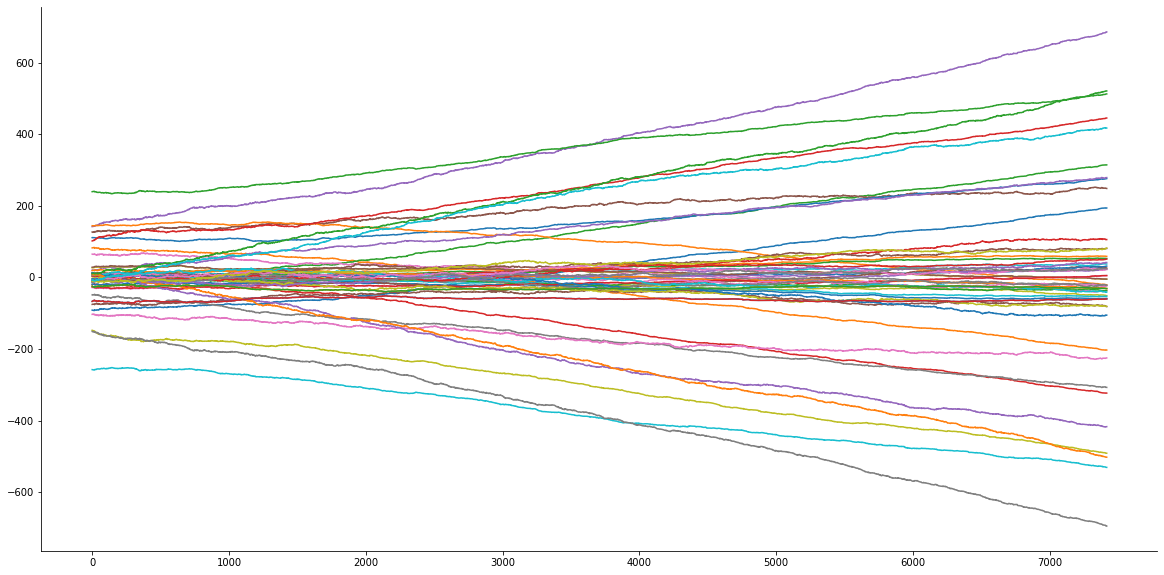

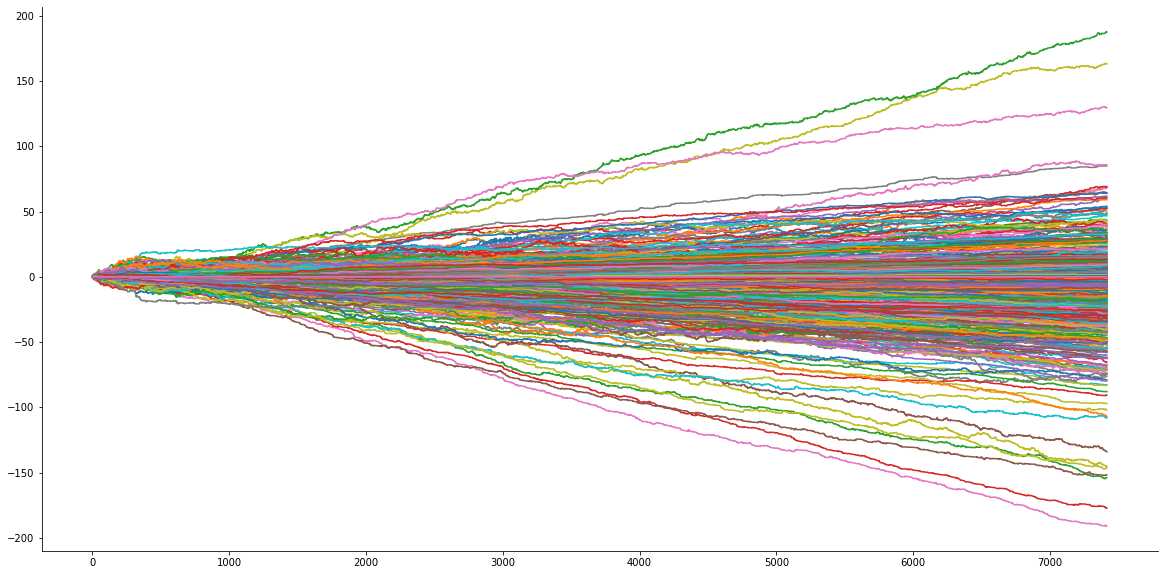

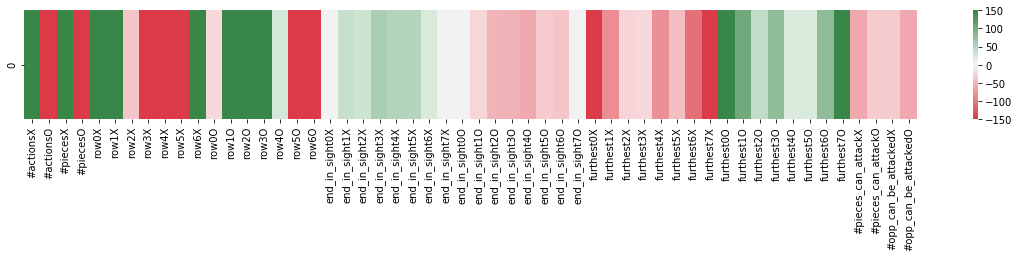

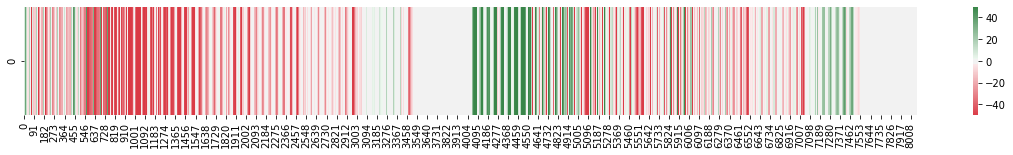

In [62]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(θ)-8064):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(θ)-8064, len(θ), 10):
    x = [j for j in range(len(θs))]
    y = [θs[j][i] for j in range(len(θs))]
    ax.plot(x, y)
sns.despine()
plt.show()

FACTOR=150
cmap = sns.diverging_palette(10, 133, as_cmap=True)
lbls = ['#actionsX', '#actionsO', '#piecesX', '#piecesO'] + [f'row{r}{p}' for p in [X, O] for r in range(N-1)] + \
       [f'end_in_sight{c}{p}' for p in [X, O] for c in range(N)] + [f'furthest{c}{p}' for p in [X, O] for c in range(N)] + \
       ['#pieces_can_attackX', '#pieces_can_attackO', '#opp_can_be_attackedX', '#opp_can_be_attackedO']
fig, ax = plt.subplots(figsize=(20, 2))
sns.heatmap([θ[:len(θ)-8064]], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax, xticklabels=lbls)
plt.show()


FACTOR=50
fig, ax = plt.subplots(figsize=(20, 2))
sns.heatmap([θ[len(θ)-8064:]], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax)
plt.show()

In [46]:
TREESTRAP, RANDOM, HUMAN = 0, 1, 2

def ab_pruning(state, depth, α, β, θ, isMax):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxV = -INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=False)
            maxV = max(maxV, value)
            α = max(α, value)
            if β <= α:
                break
        return maxV
    else:
        minV = +INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=True)
            minV = min(minV, value)
            β = min(β, value)
            if β <= α:
                break
        return minV

def random_move(state, θ=None, depth=None):
    if depth is not None or θ is not None:
        raise ValueError 
    actions = state.actions()
    return actions[np.random.choice([i for i in range(len(actions))])]

def tree_strap_move(state, θ, depth=5):
    if depth is None:
        raise ValueError 
    
    actions = []
    for action in state.actions():
        result = State(state)
        result.move(action)
        # If terminal state, no need to search
        if result.terminal_test() is not None:
            rn = result.terminal_test()
            actions.append((rn, action))
        else:
            isMax = True if result.turn == X else False
            actions.append((ab_pruning(result, depth, -INF, INF, θ, isMax=isMax), action))
    
    if state.turn == X:
        #print(actions)
        return max(actions)[1]
    return min(actions)[1]

def play(playerX=TREESTRAP, playerO=HUMAN, θX=None, θO=None, depthX=None, depthO=None, printing=False):
    if playerX == HUMAN:
        raise ValueError('You Monster!')
        
    s = State()
    s.turn = np.random.choice([X, O])
    turn = 0
    
    def play_human(ai):
        print(s)
        while s.terminal_test() is None:
            if s.turn == O:
                print('\n', list(enumerate(s.actions())), sep='')
                i = int(input())
                s.move(s.actions()[i])
            else:
                s.move(MOVE[playerX](s, θX, depthX))

            print(s)
        print('\nGame Over!')
    
    if playerO == HUMAN:
        play_human(ai=playerX)
    else:
        print(s) if printing else None
        while s.terminal_test() is None:
            if s.turn == X:
                if turn > 8:
                    s.move(MOVE[playerX](s, θX, depthX+2))
                else:
                     s.move(MOVE[playerX](s, θX, depthX))
            else:
                if turn > 8:
                    s.move(MOVE[playerO](s, θO, depthO+2))
                else:
                    s.move(MOVE[playerO](s, θO, depthO))
            print(s) if printing else None
            turn += 1
            
    θs.append(np.copy(θ))
    return int(s.terminal_test() > 0)

def validate(nGames=1, playerX=TREESTRAP, playerO=RANDOM, θX=θ, θO=None, depthX=2, depthO=None):
    wins = 0
    for _ in range(nGames):
        wins += play(playerX, playerO, θX, θO, depthX, depthO, printing=False)
    p = wins/nGames
    return p, (max(0, p - 1.96*np.sqrt(p*(1-p)/nGames)), min(1, p + 1.96*np.sqrt(p*(1-p)/nGames)))

MOVE = {TREESTRAP: tree_strap_move, RANDOM: random_move}

#validate(nGames=10)

In [63]:
play(playerX=TREESTRAP, playerO=HUMAN, θX=θ, θO=None, depthX=3, depthO=None, printing=False)

_________________
|X|X|X|X|X|X|X|X|   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63
_________________
|X|X|X|X|X|X| |X|   0  1  2  3  4  5  6  7
| | | | | | |X| |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63

[(0, (56, 48)), (1, (57, 49)), (2, (58, 50)), (3, (59, 51)), (4, (60, 52)), (5, (61, 53)), (6, (62, 54)), (7, (63, 55))]
4
_________________
|X|X|X|X|X|X| |X|   0  1  2  3  4  5  6  7
| | | | | | |X| |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | |

1
_________________
|X|X|X|X| | | |X|   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | |O| | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O| |O|O| |  56 57 58 59 60 61 62 63
_________________
|X|X|X|X| | | | |   0  1  2  3  4  5  6  7
| | | | | | | |X|   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | |O| | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O| |O|O| |  56 57 58 59 60 61 62 63

[(0, (29, 21)), (1, (56, 48)), (2, (57, 49)), (3, (58, 50)), (4, (59, 51)), (5, (61, 53)), (6, (62, 54))]
0
_________________
|X|X|X|X| | | | |   0  1  2  3  4  5  6  7
| | | | | | | |X|   8  9 10 11 12 13 14 15
| | | | | |O| | |  16 17 18 19 20 21 22 23
| | | | | | | | | 

0

In [ ]:
def opponent_move(state):
    # Do ab_search in case of winning move